In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
activation functions and their derivatives
"""

def relu_kth(x, k):
    return np.maximum(x**k, 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def d_relu_kth(x, k):
    return k * x**(k-1) * (x > 0)

# display(relu(f_xi))
# display(d_relu(f_xi))


In [3]:
"""
Numerical approach at
https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf
equation (3) on page 3 and section 3.3 on page 7 
"""

# K(x, x') = <x, x'> E[sig'(<w, x>)sig'(<w, x'>)] + E[sig(<w, x>)sig(<w, x'>)]
# E {w ~ N(0, 1)}

def numerical_kernel_entry(x, y, num_samples=1000):

    w1, w2 = np.random.normal(0.0, 1.0, size=[2, num_samples])

    w1x = w1 * x
    w1y = w1 * y
    sigma_w1x = relu(w1x)
    sigma_w1y = relu(w1y)

    w2x = w2 * x
    w2y = w2 * y
    sigma_w2x = d_relu(w2x)
    sigma_w2y = d_relu(w2y)

    expection_1 = sigma_w1x.dot(sigma_w1y) / num_samples
    expection_2 = sigma_w2x.dot(sigma_w2y) / num_samples
    
    return (x * y) * expection_1 + expection_2

In [4]:
"""
analytic solution: Equation (4)-(5) on page 3

u = <x, x'> / ||x|| ||x'||

k(u) = u k_0(u) + k_1(u)

k_0 = 1/pi (pi - arccos(u))
k_1 = 1/pi (u (pi - arccos(u)) + sqrt(1 - u^2))

assuming x == x'
"""

def kappa(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return u * k_0 + k_1

def analytic_kernel_entry(x, y):
    norm_prod = np.linalg.norm(x) * np.linalg.norm(y)
    inner_prod = x * y
    u = inner_prod / norm_prod
    return norm_prod * kappa(u)

In [5]:
# execute
def calc_NTK(kernel_entry_func):
    num_inputs = 100
    x = np.linspace(-1.0, 1.0, num=num_inputs)

    # make kernel
    kernel = np.zeros((num_inputs, num_inputs))

    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = kernel_entry_func(x[i], x[j])
    
    # sort eigenvalues in descending order
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(np.linalg.eigvals(kernel))[::-1] 
    plt.plot(eigenvalues)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


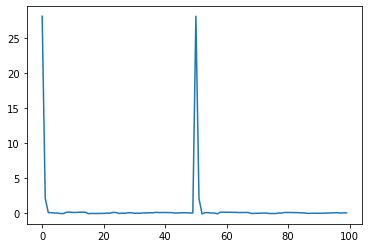

In [6]:
calc_NTK(numerical_kernel_entry)

C:\Users\genglinliu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


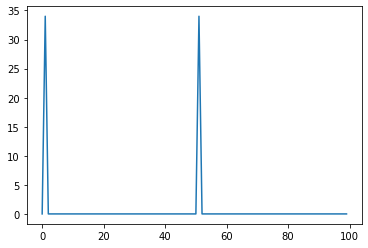

In [7]:
calc_NTK(analytic_kernel_entry)